In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/home/obesity')
from obesity.snp_encoding_traintest_split import snp_fast_encoding_and_labeling,get_scaled_phenotype_data,snp_fast_encoding_and_labeling_p
from obesity.model import dense_model
from obesity.model_evaluation import metric_array,show_train_history
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
train_obesity_snp_data_path = '/home/obesity/snp_data/snp_data_20210625/male_train_snp_obesity_SNP_604091_#_1608.tsv'
train_normal_snp_data_path = '/home/obesity/snp_data/snp_data_20210625/male_train_snp_normal_SNP_604091_#_6332.tsv'
valid_obesity_snp_data_path = '/home/obesity/snp_data/snp_data_20210625/male_valid_snp_obesity_SNP_604091_#_159.tsv'
valid_normal_snp_data_path = '/home/obesity/snp_data/snp_data_20210625/male_valid_snp_normal_SNP_604091_#_685.tsv'
test_obesity_snp_data_path = '/home/obesity/snp_data/snp_data_20210625/male_test_snp_obesity_SNP_604091_#_216.tsv'
test_normal_snp_data_path = '/home/obesity/snp_data/snp_data_20210625/male_test_snp_normal_SNP_604091_#_780.tsv'

In [3]:
train_obesity_phenotype_path = '/home/obesity/input_data/phenotype_20210625/male_train_snp_obesity.csv'
train_normal_phenotype_path = '/home/obesity/input_data/phenotype_20210625/male_train_snp_normal.csv'
valid_obesity_phenotype_path = '/home/obesity/input_data/phenotype_20210625/male_valid_snp_obesity.csv'
valid_normal_phenotype_path = '/home/obesity/input_data/phenotype_20210625/male_valid_snp_normal.csv'
test_obesity_phenotype_path = '/home/obesity/input_data/phenotype_20210625/male_test_snp_obesity.csv'
test_normal_phenotype_path = '/home/obesity/input_data/phenotype_20210625/male_test_snp_normal.csv'

In [ ]:
train_data, train_labels,train_phenotype_data = snp_fast_encoding_and_labeling_p(train_normal_snp_data_path, train_obesity_snp_data_path, 
                                                                               train_normal_phenotype_path, train_obesity_phenotype_path,balance=True)
valid_data, valid_labels,valid_phenotype_data = snp_fast_encoding_and_labeling_p(valid_normal_snp_data_path, valid_obesity_snp_data_path,
                                                                               valid_normal_phenotype_path, valid_obesity_phenotype_path,balance=True)
test_data, test_labels,test_phenotype_data = snp_fast_encoding_and_labeling_p(test_normal_snp_data_path, test_obesity_snp_data_path,
                                                                            test_normal_phenotype_path, test_obesity_phenotype_path)

In [103]:
#train_phenotype_data = get_scaled_phenotype_data(train_normal_phenotype_path, train_obesity_phenotype_path)
#valid_phenotype_data = get_scaled_phenotype_data(valid_normal_phenotype_path, valid_obesity_phenotype_path)
#test_phenotype_data = get_scaled_phenotype_data(test_normal_phenotype_path, test_obesity_phenotype_path)


In [104]:
train_phenotype_data

array([[-1.  , -0.2 ],
       [-1.  ,  0.45],
       [-1.  , -0.2 ],
       ...,
       [-1.  , -0.5 ],
       [-1.  ,  0.6 ],
       [-1.  , -0.8 ]])

In [140]:
from tensorflow.keras.layers import Concatenate, BatchNormalization
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input,Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import Model
from tensorflow.keras import optimizers
def dense_model(train_data):
    #get number of columns in training data
    n_cols = train_data.shape[1]
    input_ = Input(shape=(n_cols))
 #   input_2 = Input(shape=(4))
    e = Embedding(11, 1)(input_)
    x = Flatten()(e)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.5)(x)
 #   c = Concatenate(axis=1)([x, input_2])
#    x = Dense(16, activation='relu')(c)
#    x = BatchNormalization()(x)
#    x = Dropout(0.5)(x)
    # Output- Layer
    output = Dense(1, activation = "sigmoid")(x)
    
    model = Model(input_, output)
    return model

In [141]:
model1 = dense_model(train_data)
model1.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 10202)]      0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 10202, 8)     88          input_23[0][0]                   
__________________________________________________________________________________________________
flatten_15 (Flatten)            (None, 81616)        0           embedding_15[0][0]               
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 2)]          0                                            
______________________________________________________________________________________

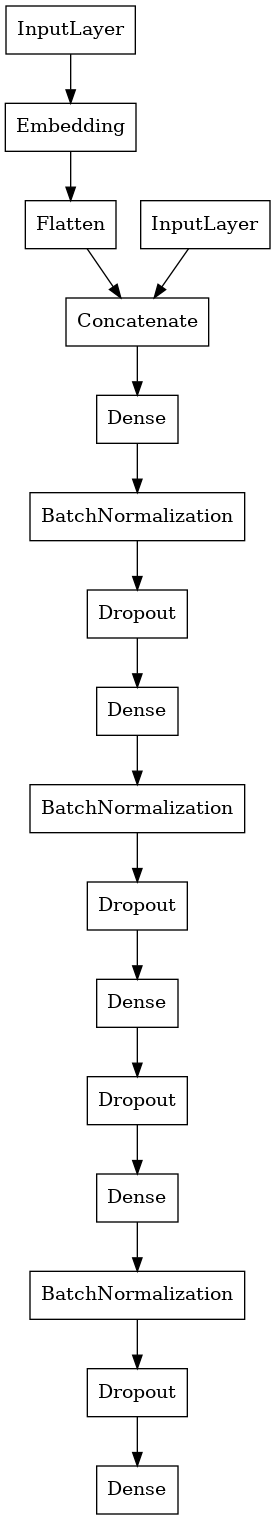

In [142]:

from tensorflow.keras.utils import plot_model
plot_model(model1, show_layer_names=False)

In [143]:
#from sklearn.utils import shuffle
#train_data, train_labels=shuffle(train_data, train_labels)

In [144]:
# callbacks
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                              patience=50,verbose=1)
e_s = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      min_delta=0,
                                      patience=300,
                                      verbose=0, mode='min')

In [145]:
model1.compile(optimizer = optimizers.Adam(lr=5*1e-4),
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

In [146]:
t_m = model1.fit([train_data,train_phenotype_data], train_labels,
                    validation_data=([valid_data,valid_phenotype_data], valid_labels),
                 batch_size=2000, epochs=500,callbacks=[e_s])

Epoch 1/500
2/2 [==============================] - 1s 267ms/step - loss: 0.9840 - accuracy: 0.4869 - val_loss: 0.6921 - val_accuracy: 0.5220
Epoch 2/500
2/2 [==============================] - 0s 158ms/step - loss: 0.8900 - accuracy: 0.5330 - val_loss: 0.6903 - val_accuracy: 0.5346
Epoch 3/500
2/2 [==============================] - 0s 158ms/step - loss: 0.8715 - accuracy: 0.5404 - val_loss: 0.6885 - val_accuracy: 0.5283
Epoch 4/500
2/2 [==============================] - 0s 155ms/step - loss: 0.7998 - accuracy: 0.5721 - val_loss: 0.6866 - val_accuracy: 0.5314
Epoch 5/500
2/2 [==============================] - 0s 160ms/step - loss: 0.8193 - accuracy: 0.5681 - val_loss: 0.6845 - val_accuracy: 0.5503
Epoch 6/500
2/2 [==============================] - 0s 181ms/step - loss: 0.7961 - accuracy: 0.5693 - val_loss: 0.6821 - val_accuracy: 0.5943
Epoch 7/500
2/2 [==============================] - 0s 181ms/step - loss: 0.7756 - accuracy: 0.5939 - val_loss: 0.6789 - val_accuracy: 0.6226
Epoch 8/500
2

Epoch 59/500
2/2 [==============================] - 0s 163ms/step - loss: 0.1697 - accuracy: 0.9552 - val_loss: 0.8730 - val_accuracy: 0.5472
Epoch 60/500
2/2 [==============================] - 0s 171ms/step - loss: 0.1681 - accuracy: 0.9521 - val_loss: 0.8817 - val_accuracy: 0.5503
Epoch 61/500
2/2 [==============================] - 0s 176ms/step - loss: 0.1665 - accuracy: 0.9530 - val_loss: 0.8910 - val_accuracy: 0.5503
Epoch 62/500
2/2 [==============================] - 0s 185ms/step - loss: 0.1590 - accuracy: 0.9590 - val_loss: 0.8998 - val_accuracy: 0.5503
Epoch 63/500
2/2 [==============================] - 0s 189ms/step - loss: 0.1653 - accuracy: 0.9555 - val_loss: 0.9042 - val_accuracy: 0.5503
Epoch 64/500
2/2 [==============================] - 0s 186ms/step - loss: 0.1535 - accuracy: 0.9655 - val_loss: 0.9422 - val_accuracy: 0.5503
Epoch 65/500
2/2 [==============================] - 0s 176ms/step - loss: 0.1476 - accuracy: 0.9627 - val_loss: 0.9820 - val_accuracy: 0.5472
Epoch 

2/2 [==============================] - 0s 172ms/step - loss: 0.0412 - accuracy: 0.9956 - val_loss: 0.3301 - val_accuracy: 0.8994
Epoch 174/500
2/2 [==============================] - 0s 171ms/step - loss: 0.0418 - accuracy: 0.9950 - val_loss: 0.3267 - val_accuracy: 0.8994
Epoch 175/500
2/2 [==============================] - 0s 165ms/step - loss: 0.0411 - accuracy: 0.9966 - val_loss: 0.3225 - val_accuracy: 0.9025
Epoch 176/500
2/2 [==============================] - 0s 183ms/step - loss: 0.0391 - accuracy: 0.9966 - val_loss: 0.3168 - val_accuracy: 0.9025
Epoch 177/500
2/2 [==============================] - 0s 172ms/step - loss: 0.0418 - accuracy: 0.9947 - val_loss: 0.3116 - val_accuracy: 0.9057
Epoch 178/500
2/2 [==============================] - 0s 185ms/step - loss: 0.0402 - accuracy: 0.9963 - val_loss: 0.3064 - val_accuracy: 0.9088
Epoch 179/500
2/2 [==============================] - 0s 181ms/step - loss: 0.0401 - accuracy: 0.9947 - val_loss: 0.3028 - val_accuracy: 0.9151
Epoch 180/500

2/2 [==============================] - 0s 175ms/step - loss: 0.0203 - accuracy: 0.9991 - val_loss: 0.1989 - val_accuracy: 0.9528
Epoch 288/500
2/2 [==============================] - 0s 177ms/step - loss: 0.0225 - accuracy: 0.9978 - val_loss: 0.1942 - val_accuracy: 0.9528
Epoch 289/500
2/2 [==============================] - 0s 183ms/step - loss: 0.0234 - accuracy: 0.9981 - val_loss: 0.1927 - val_accuracy: 0.9528
Epoch 290/500
2/2 [==============================] - 0s 180ms/step - loss: 0.0229 - accuracy: 0.9984 - val_loss: 0.1919 - val_accuracy: 0.9528
Epoch 291/500
2/2 [==============================] - 0s 181ms/step - loss: 0.0204 - accuracy: 0.9991 - val_loss: 0.1917 - val_accuracy: 0.9528
Epoch 292/500
2/2 [==============================] - 0s 180ms/step - loss: 0.0202 - accuracy: 0.9988 - val_loss: 0.1935 - val_accuracy: 0.9528
Epoch 293/500
2/2 [==============================] - 0s 173ms/step - loss: 0.0217 - accuracy: 0.9981 - val_loss: 0.1971 - val_accuracy: 0.9528
Epoch 294/500

2/2 [==============================] - 0s 168ms/step - loss: 0.0137 - accuracy: 0.9988 - val_loss: 0.1971 - val_accuracy: 0.9497
Epoch 402/500
2/2 [==============================] - 0s 165ms/step - loss: 0.0126 - accuracy: 0.9997 - val_loss: 0.1936 - val_accuracy: 0.9528
Epoch 403/500
2/2 [==============================] - 0s 175ms/step - loss: 0.0135 - accuracy: 0.9997 - val_loss: 0.1904 - val_accuracy: 0.9528
Epoch 404/500
2/2 [==============================] - 0s 181ms/step - loss: 0.0140 - accuracy: 0.9988 - val_loss: 0.1870 - val_accuracy: 0.9528
Epoch 405/500
2/2 [==============================] - 0s 173ms/step - loss: 0.0145 - accuracy: 0.9991 - val_loss: 0.1849 - val_accuracy: 0.9497
Epoch 406/500
2/2 [==============================] - 0s 169ms/step - loss: 0.0127 - accuracy: 0.9991 - val_loss: 0.1835 - val_accuracy: 0.9497
Epoch 407/500
2/2 [==============================] - 0s 176ms/step - loss: 0.0146 - accuracy: 0.9984 - val_loss: 0.1821 - val_accuracy: 0.9497
Epoch 408/500

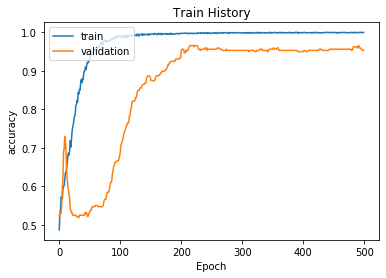

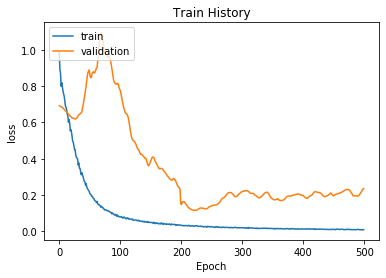

In [147]:
from obesity.model_evaluation import metric_array,show_train_history
show_train_history(model1.history ,'accuracy','val_accuracy')
show_train_history(model1.history ,'loss','val_loss')

In [150]:
metric_array([valid_data,valid_phenotype_data], valid_labels, model1)

{'accuracy': 0.9528301886792453,
 'precision': 0.9864864864864865,
 'sensitivity': 0.9182389937106918,
 'specificity': 0.9874213836477987,
 'f1': 0.9511400651465798,
 'mcc': 0.9078355257492409}

In [151]:
metric_array([test_data,test_phenotype_data], test_labels, model1)

{'accuracy': 0.7118473895582329,
 'precision': 0.2795031055900621,
 'sensitivity': 0.20833333333333334,
 'specificity': 0.8512820512820513,
 'f1': 0.23872679045092837,
 'mcc': 0.06673848617609501}

In [231]:
from tensorflow.keras.models import load_model
autoencoder_embedding_path = '/home/obesity/obesity_bmi_prediction/model/autoencoder_embedding_991_001.h5'
autoencoder_embedding = load_model(autoencoder_embedding_path)

In [232]:
from tensorflow.keras.utils import to_categorical
train_data_onehot = to_categorical(train_data)
valid_data_onehot = to_categorical(valid_data)
test_data_onehot = to_categorical(test_data)

In [233]:
train_data_embedded = autoencoder_embedding.predict(train_data_onehot)
valid_data_embedded = autoencoder_embedding.predict(valid_data_onehot)
test_data_embedded = autoencoder_embedding.predict(test_data_onehot)

In [234]:
train_data_embedded.shape

(8548, 128)

In [255]:
from tensorflow.keras.layers import Concatenate, BatchNormalization
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input,Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import Model
from tensorflow.keras import optimizers
def dense_model(train_data):
    #get number of columns in training data
    n_cols = train_data.shape[1]
    input_ = Input(shape=(n_cols))
  #  input_2 = Input(shape=(4))
    #x = Dense(n_cols, activation='relu')(x)
    #x = BatchNormalization()(x)
    #x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(input_)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.5)(x)
#    c = Concatenate(axis=1)([x, input_2])
    x = Dense(16, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    # Output- Layer
    output = Dense(1, activation = "sigmoid")(x)
    model = Model(input_, output)
    
    return model

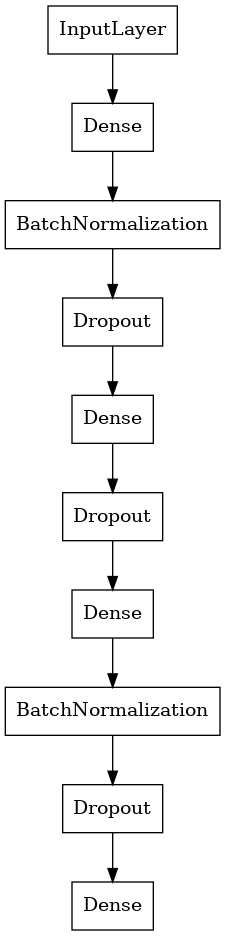

In [256]:
model = dense_model(train_data_embedded)
plot_model(model, show_layer_names=False)

In [257]:
model.compile(optimizer = optimizers.Adam(lr=5*1e-4),
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

In [258]:
c_l = train_labels

In [239]:
c = np.c_[train_data_embedded.reshape(len(train_data_embedded), -1), train_phenotype_data.reshape(len(train_phenotype_data), -1)]

In [36]:
np.c_[train_data_embedded.reshape(len(train_data_embedded), -1), train_phenotype_data.reshape(len(train_phenotype_data), -1)].shape

(7572, 132)

In [27]:
from sklearn.utils import shuffle
c, c_l = shuffle(c, c_l, random_state=0)

In [37]:
a2 = c[:, :train_data_embedded.size//len(train_data_embedded)].reshape(train_data_embedded.shape)
b2 = c[:, train_data_embedded.size//len(train_data_embedded):].reshape(train_phenotype_data.shape)

In [259]:
model.fit(train_data_embedded, train_labels,
                validation_data=(valid_data_embedded, valid_labels),batch_size=500, epochs=10000)

Epoch 1/10000
18/18 [==============================] - 0s 17ms/step - loss: 0.9711 - accuracy: 0.4994 - val_loss: 0.7103 - val_accuracy: 0.5158
Epoch 2/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.9510 - accuracy: 0.5008 - val_loss: 0.7069 - val_accuracy: 0.5217
Epoch 3/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.9195 - accuracy: 0.5039 - val_loss: 0.7048 - val_accuracy: 0.5296
Epoch 4/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.9261 - accuracy: 0.5032 - val_loss: 0.7025 - val_accuracy: 0.5356
Epoch 5/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.9015 - accuracy: 0.5044 - val_loss: 0.7012 - val_accuracy: 0.5366
Epoch 6/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.8795 - accuracy: 0.5055 - val_loss: 0.7007 - val_accuracy: 0.5277
Epoch 7/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.8700 - accuracy: 0.5034 - val_loss: 0.7004 - val_accuracy: 0.517

Epoch 58/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.7043 - accuracy: 0.5120 - val_loss: 0.6890 - val_accuracy: 0.5395
Epoch 59/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.6973 - accuracy: 0.5287 - val_loss: 0.6889 - val_accuracy: 0.5385
Epoch 60/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.6990 - accuracy: 0.5188 - val_loss: 0.6889 - val_accuracy: 0.5405
Epoch 61/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.7026 - accuracy: 0.5129 - val_loss: 0.6888 - val_accuracy: 0.5455
Epoch 62/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.7016 - accuracy: 0.5139 - val_loss: 0.6888 - val_accuracy: 0.5415
Epoch 63/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.6969 - accuracy: 0.5240 - val_loss: 0.6887 - val_accuracy: 0.5395
Epoch 64/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.7024 - accuracy: 0.5159 - val_loss: 0.6887 - val_accuracy:

Epoch 115/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.6831 - accuracy: 0.5566 - val_loss: 0.6839 - val_accuracy: 0.5504
Epoch 116/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.6856 - accuracy: 0.5464 - val_loss: 0.6839 - val_accuracy: 0.5514
Epoch 117/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.6837 - accuracy: 0.5512 - val_loss: 0.6838 - val_accuracy: 0.5474
Epoch 118/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.6851 - accuracy: 0.5518 - val_loss: 0.6839 - val_accuracy: 0.5464
Epoch 119/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.6823 - accuracy: 0.5503 - val_loss: 0.6838 - val_accuracy: 0.5455
Epoch 120/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.6835 - accuracy: 0.5577 - val_loss: 0.6837 - val_accuracy: 0.5504
Epoch 121/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.6814 - accuracy: 0.5590 - val_loss: 0.6837 - val_ac

18/18 [==============================] - 0s 8ms/step - loss: 0.6529 - accuracy: 0.6206 - val_loss: 0.6824 - val_accuracy: 0.5652
Epoch 228/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.6526 - accuracy: 0.6206 - val_loss: 0.6823 - val_accuracy: 0.5642
Epoch 229/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.6546 - accuracy: 0.6225 - val_loss: 0.6822 - val_accuracy: 0.5632
Epoch 230/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.6527 - accuracy: 0.6194 - val_loss: 0.6823 - val_accuracy: 0.5632
Epoch 231/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.6521 - accuracy: 0.6268 - val_loss: 0.6825 - val_accuracy: 0.5652
Epoch 232/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.6496 - accuracy: 0.6259 - val_loss: 0.6826 - val_accuracy: 0.5603
Epoch 233/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.6473 - accuracy: 0.6234 - val_loss: 0.6830 - val_accuracy: 0.5613
E

18/18 [==============================] - 0s 8ms/step - loss: 0.6073 - accuracy: 0.6748 - val_loss: 0.6875 - val_accuracy: 0.5702
Epoch 340/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.6066 - accuracy: 0.6738 - val_loss: 0.6882 - val_accuracy: 0.5751
Epoch 341/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.6059 - accuracy: 0.6687 - val_loss: 0.6890 - val_accuracy: 0.5741
Epoch 342/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.6030 - accuracy: 0.6813 - val_loss: 0.6890 - val_accuracy: 0.5741
Epoch 343/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.6060 - accuracy: 0.6730 - val_loss: 0.6887 - val_accuracy: 0.5781
Epoch 344/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.5958 - accuracy: 0.6900 - val_loss: 0.6892 - val_accuracy: 0.5741
Epoch 345/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.6068 - accuracy: 0.6790 - val_loss: 0.6882 - val_accuracy: 0.58

18/18 [==============================] - 0s 9ms/step - loss: 0.5614 - accuracy: 0.7142 - val_loss: 0.7163 - val_accuracy: 0.5652
Epoch 452/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.5674 - accuracy: 0.7168 - val_loss: 0.7165 - val_accuracy: 0.5652
Epoch 453/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.5650 - accuracy: 0.7115 - val_loss: 0.7169 - val_accuracy: 0.5613
Epoch 454/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.5629 - accuracy: 0.7144 - val_loss: 0.7187 - val_accuracy: 0.5593
Epoch 455/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.5667 - accuracy: 0.7139 - val_loss: 0.7170 - val_accuracy: 0.5642
Epoch 456/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.5644 - accuracy: 0.7178 - val_loss: 0.7167 - val_accuracy: 0.5652
Epoch 457/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.5648 - accuracy: 0.7095 - val_loss: 0.7159 - val_accuracy: 0.5642


18/18 [==============================] - 0s 9ms/step - loss: 0.5289 - accuracy: 0.7405 - val_loss: 0.7349 - val_accuracy: 0.5524
Epoch 564/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.5362 - accuracy: 0.7390 - val_loss: 0.7369 - val_accuracy: 0.5524
Epoch 565/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.5365 - accuracy: 0.7355 - val_loss: 0.7377 - val_accuracy: 0.5603
Epoch 566/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.5341 - accuracy: 0.7340 - val_loss: 0.7386 - val_accuracy: 0.5534
Epoch 567/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.5365 - accuracy: 0.7417 - val_loss: 0.7390 - val_accuracy: 0.5543
Epoch 568/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.5370 - accuracy: 0.7357 - val_loss: 0.7392 - val_accuracy: 0.5563
Epoch 569/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.5414 - accuracy: 0.7284 - val_loss: 0.7365 - val_accuracy: 0.5524
E

18/18 [==============================] - 0s 8ms/step - loss: 0.5096 - accuracy: 0.7580 - val_loss: 0.7614 - val_accuracy: 0.5642
Epoch 676/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.5122 - accuracy: 0.7506 - val_loss: 0.7631 - val_accuracy: 0.5642
Epoch 677/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.5188 - accuracy: 0.7426 - val_loss: 0.7629 - val_accuracy: 0.5672
Epoch 678/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.5126 - accuracy: 0.7501 - val_loss: 0.7597 - val_accuracy: 0.5613
Epoch 679/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.5077 - accuracy: 0.7519 - val_loss: 0.7612 - val_accuracy: 0.5603
Epoch 680/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.5101 - accuracy: 0.7489 - val_loss: 0.7614 - val_accuracy: 0.5672
Epoch 681/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.5133 - accuracy: 0.7530 - val_loss: 0.7612 - val_accuracy: 0.5692
E

18/18 [==============================] - 0s 8ms/step - loss: 0.5003 - accuracy: 0.7554 - val_loss: 0.7730 - val_accuracy: 0.5425
Epoch 788/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4909 - accuracy: 0.7639 - val_loss: 0.7733 - val_accuracy: 0.5366
Epoch 789/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.5050 - accuracy: 0.7514 - val_loss: 0.7700 - val_accuracy: 0.5415
Epoch 790/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4877 - accuracy: 0.7643 - val_loss: 0.7717 - val_accuracy: 0.5445
Epoch 791/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4942 - accuracy: 0.7632 - val_loss: 0.7713 - val_accuracy: 0.5464
Epoch 792/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4992 - accuracy: 0.7630 - val_loss: 0.7719 - val_accuracy: 0.5514
Epoch 793/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4958 - accuracy: 0.7599 - val_loss: 0.7725 - val_accuracy: 0.5484
E

18/18 [==============================] - 0s 7ms/step - loss: 0.4717 - accuracy: 0.7792 - val_loss: 0.7996 - val_accuracy: 0.5514
Epoch 900/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4816 - accuracy: 0.7706 - val_loss: 0.8005 - val_accuracy: 0.5553
Epoch 901/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4894 - accuracy: 0.7684 - val_loss: 0.8010 - val_accuracy: 0.5543
Epoch 902/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4798 - accuracy: 0.7680 - val_loss: 0.8002 - val_accuracy: 0.5543
Epoch 903/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4883 - accuracy: 0.7659 - val_loss: 0.8000 - val_accuracy: 0.5573
Epoch 904/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4797 - accuracy: 0.7771 - val_loss: 0.7977 - val_accuracy: 0.5543
Epoch 905/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4887 - accuracy: 0.7693 - val_loss: 0.7950 - val_accuracy: 0.5514
E

18/18 [==============================] - 0s 7ms/step - loss: 0.4687 - accuracy: 0.7815 - val_loss: 0.7965 - val_accuracy: 0.5583
Epoch 1012/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4720 - accuracy: 0.7773 - val_loss: 0.7975 - val_accuracy: 0.5534
Epoch 1013/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4698 - accuracy: 0.7794 - val_loss: 0.7998 - val_accuracy: 0.5514
Epoch 1014/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4732 - accuracy: 0.7771 - val_loss: 0.7996 - val_accuracy: 0.5543
Epoch 1015/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4739 - accuracy: 0.7723 - val_loss: 0.7996 - val_accuracy: 0.5534
Epoch 1016/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4692 - accuracy: 0.7801 - val_loss: 0.7991 - val_accuracy: 0.5534
Epoch 1017/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4632 - accuracy: 0.7823 - val_loss: 0.8025 - val_accuracy: 0.

Epoch 1067/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4719 - accuracy: 0.7749 - val_loss: 0.8098 - val_accuracy: 0.5524
Epoch 1068/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4588 - accuracy: 0.7866 - val_loss: 0.8094 - val_accuracy: 0.5593
Epoch 1069/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4557 - accuracy: 0.7921 - val_loss: 0.8112 - val_accuracy: 0.5534
Epoch 1070/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4700 - accuracy: 0.7776 - val_loss: 0.8116 - val_accuracy: 0.5543
Epoch 1071/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4620 - accuracy: 0.7847 - val_loss: 0.8106 - val_accuracy: 0.5514
Epoch 1072/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4583 - accuracy: 0.7902 - val_loss: 0.8091 - val_accuracy: 0.5514
Epoch 1073/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4563 - accuracy: 0.7823 - val_loss: 0.8080 -

18/18 [==============================] - 0s 8ms/step - loss: 0.4652 - accuracy: 0.7785 - val_loss: 0.8143 - val_accuracy: 0.5474
Epoch 1124/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4619 - accuracy: 0.7830 - val_loss: 0.8115 - val_accuracy: 0.5494
Epoch 1125/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4571 - accuracy: 0.7902 - val_loss: 0.8139 - val_accuracy: 0.5514
Epoch 1126/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4594 - accuracy: 0.7872 - val_loss: 0.8160 - val_accuracy: 0.5543
Epoch 1127/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4634 - accuracy: 0.7802 - val_loss: 0.8161 - val_accuracy: 0.5534
Epoch 1128/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4605 - accuracy: 0.7824 - val_loss: 0.8159 - val_accuracy: 0.5524
Epoch 1129/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4614 - accuracy: 0.7819 - val_loss: 0.8162 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.4439 - accuracy: 0.7936 - val_loss: 0.8393 - val_accuracy: 0.5504
Epoch 1236/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4547 - accuracy: 0.7888 - val_loss: 0.8391 - val_accuracy: 0.5504
Epoch 1237/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4430 - accuracy: 0.7940 - val_loss: 0.8427 - val_accuracy: 0.5534
Epoch 1238/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4345 - accuracy: 0.8012 - val_loss: 0.8439 - val_accuracy: 0.5543
Epoch 1239/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4540 - accuracy: 0.7898 - val_loss: 0.8453 - val_accuracy: 0.5534
Epoch 1240/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4393 - accuracy: 0.7988 - val_loss: 0.8433 - val_accuracy: 0.5524
Epoch 1241/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4458 - accuracy: 0.7936 - val_loss: 0.8457 - val_accuracy: 0.

18/18 [==============================] - 0s 7ms/step - loss: 0.4421 - accuracy: 0.7989 - val_loss: 0.8543 - val_accuracy: 0.5534
Epoch 1348/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4348 - accuracy: 0.8001 - val_loss: 0.8521 - val_accuracy: 0.5563
Epoch 1349/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4436 - accuracy: 0.7933 - val_loss: 0.8524 - val_accuracy: 0.5603
Epoch 1350/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4399 - accuracy: 0.7995 - val_loss: 0.8531 - val_accuracy: 0.5603
Epoch 1351/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4508 - accuracy: 0.7926 - val_loss: 0.8515 - val_accuracy: 0.5593
Epoch 1352/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4440 - accuracy: 0.7916 - val_loss: 0.8466 - val_accuracy: 0.5543
Epoch 1353/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4357 - accuracy: 0.8066 - val_loss: 0.8472 - val_accuracy: 0.

18/18 [==============================] - 0s 7ms/step - loss: 0.4271 - accuracy: 0.7983 - val_loss: 0.8768 - val_accuracy: 0.5395
Epoch 1460/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4265 - accuracy: 0.8059 - val_loss: 0.8785 - val_accuracy: 0.5435
Epoch 1461/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4264 - accuracy: 0.8043 - val_loss: 0.8779 - val_accuracy: 0.5395
Epoch 1462/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4353 - accuracy: 0.7973 - val_loss: 0.8714 - val_accuracy: 0.5415
Epoch 1463/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4285 - accuracy: 0.8037 - val_loss: 0.8701 - val_accuracy: 0.5425
Epoch 1464/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4223 - accuracy: 0.8098 - val_loss: 0.8705 - val_accuracy: 0.5484
Epoch 1465/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4267 - accuracy: 0.8083 - val_loss: 0.8729 - val_accuracy: 0.

18/18 [==============================] - 0s 7ms/step - loss: 0.4205 - accuracy: 0.8073 - val_loss: 0.8867 - val_accuracy: 0.5524
Epoch 1572/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4179 - accuracy: 0.8104 - val_loss: 0.8891 - val_accuracy: 0.5455
Epoch 1573/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4242 - accuracy: 0.8069 - val_loss: 0.8904 - val_accuracy: 0.5464
Epoch 1574/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4125 - accuracy: 0.8040 - val_loss: 0.8929 - val_accuracy: 0.5464
Epoch 1575/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4270 - accuracy: 0.8038 - val_loss: 0.8936 - val_accuracy: 0.5474
Epoch 1576/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4280 - accuracy: 0.8067 - val_loss: 0.8874 - val_accuracy: 0.5484
Epoch 1577/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.4204 - accuracy: 0.8077 - val_loss: 0.8850 - val_accuracy: 0.

18/18 [==============================] - 0s 7ms/step - loss: 0.4157 - accuracy: 0.8118 - val_loss: 0.9055 - val_accuracy: 0.5405
Epoch 1684/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4251 - accuracy: 0.8015 - val_loss: 0.9035 - val_accuracy: 0.5425
Epoch 1685/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4204 - accuracy: 0.8083 - val_loss: 0.8993 - val_accuracy: 0.5435
Epoch 1686/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4147 - accuracy: 0.8104 - val_loss: 0.8999 - val_accuracy: 0.5464
Epoch 1687/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4237 - accuracy: 0.8090 - val_loss: 0.8996 - val_accuracy: 0.5435
Epoch 1688/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4157 - accuracy: 0.8050 - val_loss: 0.9014 - val_accuracy: 0.5425
Epoch 1689/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4116 - accuracy: 0.8146 - val_loss: 0.9023 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.4146 - accuracy: 0.8101 - val_loss: 0.9305 - val_accuracy: 0.5534
Epoch 1796/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4110 - accuracy: 0.8080 - val_loss: 0.9307 - val_accuracy: 0.5553
Epoch 1797/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4007 - accuracy: 0.8193 - val_loss: 0.9297 - val_accuracy: 0.5573
Epoch 1798/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4173 - accuracy: 0.8060 - val_loss: 0.9270 - val_accuracy: 0.5563
Epoch 1799/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4054 - accuracy: 0.8161 - val_loss: 0.9265 - val_accuracy: 0.5524
Epoch 1800/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.3995 - accuracy: 0.8157 - val_loss: 0.9274 - val_accuracy: 0.5543
Epoch 1801/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4051 - accuracy: 0.8157 - val_loss: 0.9320 - val_accuracy: 0.

18/18 [==============================] - 0s 7ms/step - loss: 0.4037 - accuracy: 0.8159 - val_loss: 0.9458 - val_accuracy: 0.5494
Epoch 1908/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4101 - accuracy: 0.8141 - val_loss: 0.9442 - val_accuracy: 0.5504
Epoch 1909/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4055 - accuracy: 0.8157 - val_loss: 0.9414 - val_accuracy: 0.5524
Epoch 1910/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3971 - accuracy: 0.8204 - val_loss: 0.9398 - val_accuracy: 0.5514
Epoch 1911/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4047 - accuracy: 0.8148 - val_loss: 0.9399 - val_accuracy: 0.5534
Epoch 1912/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.3968 - accuracy: 0.8194 - val_loss: 0.9418 - val_accuracy: 0.5563
Epoch 1913/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.3998 - accuracy: 0.8172 - val_loss: 0.9407 - val_accuracy: 0.

18/18 [==============================] - 0s 7ms/step - loss: 0.3973 - accuracy: 0.8228 - val_loss: 0.9429 - val_accuracy: 0.5425
Epoch 2020/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.3986 - accuracy: 0.8207 - val_loss: 0.9396 - val_accuracy: 0.5445
Epoch 2021/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.3948 - accuracy: 0.8251 - val_loss: 0.9386 - val_accuracy: 0.5464
Epoch 2022/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.3896 - accuracy: 0.8241 - val_loss: 0.9468 - val_accuracy: 0.5494
Epoch 2023/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3992 - accuracy: 0.8228 - val_loss: 0.9534 - val_accuracy: 0.5494
Epoch 2024/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4026 - accuracy: 0.8168 - val_loss: 0.9548 - val_accuracy: 0.5543
Epoch 2025/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.4006 - accuracy: 0.8138 - val_loss: 0.9524 - val_accuracy: 0.

18/18 [==============================] - 0s 9ms/step - loss: 0.3986 - accuracy: 0.8243 - val_loss: 0.9589 - val_accuracy: 0.5435
Epoch 2132/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3901 - accuracy: 0.8248 - val_loss: 0.9616 - val_accuracy: 0.5415
Epoch 2133/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3914 - accuracy: 0.8249 - val_loss: 0.9675 - val_accuracy: 0.5415
Epoch 2134/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.4047 - accuracy: 0.8146 - val_loss: 0.9690 - val_accuracy: 0.5415
Epoch 2135/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3878 - accuracy: 0.8236 - val_loss: 0.9660 - val_accuracy: 0.5415
Epoch 2136/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3946 - accuracy: 0.8222 - val_loss: 0.9707 - val_accuracy: 0.5435
Epoch 2137/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3989 - accuracy: 0.8188 - val_loss: 0.9741 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3897 - accuracy: 0.8237 - val_loss: 0.9668 - val_accuracy: 0.5553
Epoch 2244/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3980 - accuracy: 0.8200 - val_loss: 0.9677 - val_accuracy: 0.5524
Epoch 2245/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3909 - accuracy: 0.8230 - val_loss: 0.9670 - val_accuracy: 0.5563
Epoch 2246/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3866 - accuracy: 0.8246 - val_loss: 0.9653 - val_accuracy: 0.5553
Epoch 2247/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3951 - accuracy: 0.8189 - val_loss: 0.9680 - val_accuracy: 0.5553
Epoch 2248/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3884 - accuracy: 0.8277 - val_loss: 0.9659 - val_accuracy: 0.5603
Epoch 2249/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3883 - accuracy: 0.8252 - val_loss: 0.9728 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3883 - accuracy: 0.8288 - val_loss: 0.9699 - val_accuracy: 0.5543
Epoch 2356/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3818 - accuracy: 0.8263 - val_loss: 0.9691 - val_accuracy: 0.5603
Epoch 2357/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3822 - accuracy: 0.8293 - val_loss: 0.9711 - val_accuracy: 0.5573
Epoch 2358/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3909 - accuracy: 0.8232 - val_loss: 0.9732 - val_accuracy: 0.5603
Epoch 2359/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3816 - accuracy: 0.8283 - val_loss: 0.9701 - val_accuracy: 0.5484
Epoch 2360/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3848 - accuracy: 0.8273 - val_loss: 0.9723 - val_accuracy: 0.5445
Epoch 2361/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3881 - accuracy: 0.8267 - val_loss: 0.9750 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3820 - accuracy: 0.8243 - val_loss: 1.0164 - val_accuracy: 0.5534
Epoch 2468/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3922 - accuracy: 0.8243 - val_loss: 1.0132 - val_accuracy: 0.5543
Epoch 2469/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3928 - accuracy: 0.8170 - val_loss: 1.0070 - val_accuracy: 0.5543
Epoch 2470/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3867 - accuracy: 0.8290 - val_loss: 1.0079 - val_accuracy: 0.5534
Epoch 2471/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3848 - accuracy: 0.8292 - val_loss: 1.0127 - val_accuracy: 0.5563
Epoch 2472/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3913 - accuracy: 0.8196 - val_loss: 1.0131 - val_accuracy: 0.5514
Epoch 2473/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3844 - accuracy: 0.8270 - val_loss: 1.0099 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3905 - accuracy: 0.8269 - val_loss: 1.0231 - val_accuracy: 0.5583
Epoch 2580/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3813 - accuracy: 0.8303 - val_loss: 1.0221 - val_accuracy: 0.5632
Epoch 2581/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3714 - accuracy: 0.8334 - val_loss: 1.0175 - val_accuracy: 0.5583
Epoch 2582/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3869 - accuracy: 0.8256 - val_loss: 1.0153 - val_accuracy: 0.5563
Epoch 2583/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3863 - accuracy: 0.8257 - val_loss: 1.0197 - val_accuracy: 0.5613
Epoch 2584/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3691 - accuracy: 0.8318 - val_loss: 1.0213 - val_accuracy: 0.5573
Epoch 2585/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3786 - accuracy: 0.8290 - val_loss: 1.0205 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3756 - accuracy: 0.8263 - val_loss: 1.0401 - val_accuracy: 0.5573
Epoch 2692/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3776 - accuracy: 0.8300 - val_loss: 1.0354 - val_accuracy: 0.5573
Epoch 2693/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3726 - accuracy: 0.8314 - val_loss: 1.0387 - val_accuracy: 0.5534
Epoch 2694/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3848 - accuracy: 0.8235 - val_loss: 1.0417 - val_accuracy: 0.5534
Epoch 2695/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3831 - accuracy: 0.8263 - val_loss: 1.0489 - val_accuracy: 0.5494
Epoch 2696/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3818 - accuracy: 0.8253 - val_loss: 1.0478 - val_accuracy: 0.5524
Epoch 2697/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3798 - accuracy: 0.8276 - val_loss: 1.0491 - val_accuracy: 0.

Epoch 2803/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3784 - accuracy: 0.8305 - val_loss: 1.0705 - val_accuracy: 0.5445
Epoch 2804/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3786 - accuracy: 0.8276 - val_loss: 1.0741 - val_accuracy: 0.5514
Epoch 2805/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3829 - accuracy: 0.8262 - val_loss: 1.0707 - val_accuracy: 0.5494
Epoch 2806/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3684 - accuracy: 0.8300 - val_loss: 1.0735 - val_accuracy: 0.5514
Epoch 2807/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3599 - accuracy: 0.8386 - val_loss: 1.0745 - val_accuracy: 0.5504
Epoch 2808/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3799 - accuracy: 0.8242 - val_loss: 1.0788 - val_accuracy: 0.5484
Epoch 2809/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3744 - accuracy: 0.8321 - val_loss: 1.0803

18/18 [==============================] - 0s 8ms/step - loss: 0.3806 - accuracy: 0.8244 - val_loss: 1.0487 - val_accuracy: 0.5613
Epoch 2860/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3669 - accuracy: 0.8341 - val_loss: 1.0529 - val_accuracy: 0.5603
Epoch 2861/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3651 - accuracy: 0.8346 - val_loss: 1.0574 - val_accuracy: 0.5692
Epoch 2862/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3797 - accuracy: 0.8270 - val_loss: 1.0561 - val_accuracy: 0.5642
Epoch 2863/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3711 - accuracy: 0.8349 - val_loss: 1.0601 - val_accuracy: 0.5662
Epoch 2864/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3723 - accuracy: 0.8322 - val_loss: 1.0623 - val_accuracy: 0.5662
Epoch 2865/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3668 - accuracy: 0.8349 - val_loss: 1.0663 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3618 - accuracy: 0.8352 - val_loss: 1.0925 - val_accuracy: 0.5534
Epoch 2972/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3684 - accuracy: 0.8394 - val_loss: 1.0918 - val_accuracy: 0.5484
Epoch 2973/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3744 - accuracy: 0.8292 - val_loss: 1.0957 - val_accuracy: 0.5494
Epoch 2974/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3685 - accuracy: 0.8331 - val_loss: 1.0965 - val_accuracy: 0.5484
Epoch 2975/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3641 - accuracy: 0.8347 - val_loss: 1.1018 - val_accuracy: 0.5553
Epoch 2976/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3680 - accuracy: 0.8341 - val_loss: 1.1066 - val_accuracy: 0.5583
Epoch 2977/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3640 - accuracy: 0.8367 - val_loss: 1.1027 - val_accuracy: 0

18/18 [==============================] - 0s 10ms/step - loss: 0.3726 - accuracy: 0.8348 - val_loss: 1.1101 - val_accuracy: 0.5514
Epoch 3084/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3737 - accuracy: 0.8303 - val_loss: 1.1042 - val_accuracy: 0.5553
Epoch 3085/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3739 - accuracy: 0.8267 - val_loss: 1.1013 - val_accuracy: 0.5573
Epoch 3086/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3711 - accuracy: 0.8345 - val_loss: 1.1059 - val_accuracy: 0.5573
Epoch 3087/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3638 - accuracy: 0.8373 - val_loss: 1.1052 - val_accuracy: 0.5534
Epoch 3088/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3700 - accuracy: 0.8300 - val_loss: 1.1028 - val_accuracy: 0.5563
Epoch 3089/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3625 - accuracy: 0.8383 - val_loss: 1.1062 - val_accuracy:

18/18 [==============================] - 0s 8ms/step - loss: 0.3679 - accuracy: 0.8365 - val_loss: 1.1227 - val_accuracy: 0.5563
Epoch 3196/10000
18/18 [==============================] - 0s 12ms/step - loss: 0.3615 - accuracy: 0.8354 - val_loss: 1.1220 - val_accuracy: 0.5553
Epoch 3197/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3654 - accuracy: 0.8356 - val_loss: 1.1285 - val_accuracy: 0.5563
Epoch 3198/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3645 - accuracy: 0.8340 - val_loss: 1.1243 - val_accuracy: 0.5524
Epoch 3199/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3620 - accuracy: 0.8353 - val_loss: 1.1179 - val_accuracy: 0.5534
Epoch 3200/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3620 - accuracy: 0.8373 - val_loss: 1.1192 - val_accuracy: 0.5573
Epoch 3201/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3622 - accuracy: 0.8353 - val_loss: 1.1145 - val_accuracy:

18/18 [==============================] - 0s 8ms/step - loss: 0.3574 - accuracy: 0.8431 - val_loss: 1.1186 - val_accuracy: 0.5514
Epoch 3308/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3628 - accuracy: 0.8388 - val_loss: 1.1123 - val_accuracy: 0.5524
Epoch 3309/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3602 - accuracy: 0.8326 - val_loss: 1.1113 - val_accuracy: 0.5514
Epoch 3310/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3620 - accuracy: 0.8375 - val_loss: 1.1166 - val_accuracy: 0.5514
Epoch 3311/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3661 - accuracy: 0.8352 - val_loss: 1.1198 - val_accuracy: 0.5593
Epoch 3312/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3625 - accuracy: 0.8390 - val_loss: 1.1165 - val_accuracy: 0.5642
Epoch 3313/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3624 - accuracy: 0.8380 - val_loss: 1.1142 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3572 - accuracy: 0.8443 - val_loss: 1.1533 - val_accuracy: 0.5474
Epoch 3420/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3539 - accuracy: 0.8412 - val_loss: 1.1558 - val_accuracy: 0.5474
Epoch 3421/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3649 - accuracy: 0.8343 - val_loss: 1.1565 - val_accuracy: 0.5464
Epoch 3422/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3633 - accuracy: 0.8338 - val_loss: 1.1553 - val_accuracy: 0.5385
Epoch 3423/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.3538 - accuracy: 0.8422 - val_loss: 1.1554 - val_accuracy: 0.5385
Epoch 3424/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3582 - accuracy: 0.8432 - val_loss: 1.1453 - val_accuracy: 0.5395
Epoch 3425/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3660 - accuracy: 0.8373 - val_loss: 1.1426 - val_accuracy: 0.

18/18 [==============================] - 0s 9ms/step - loss: 0.3612 - accuracy: 0.8336 - val_loss: 1.1330 - val_accuracy: 0.5583
Epoch 3532/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3727 - accuracy: 0.8324 - val_loss: 1.1375 - val_accuracy: 0.5543
Epoch 3533/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3712 - accuracy: 0.8327 - val_loss: 1.1377 - val_accuracy: 0.5514
Epoch 3534/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3680 - accuracy: 0.8308 - val_loss: 1.1360 - val_accuracy: 0.5563
Epoch 3535/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3776 - accuracy: 0.8237 - val_loss: 1.1340 - val_accuracy: 0.5563
Epoch 3536/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3553 - accuracy: 0.8415 - val_loss: 1.1304 - val_accuracy: 0.5543
Epoch 3537/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3633 - accuracy: 0.8370 - val_loss: 1.1335 - val_accuracy: 0.

18/18 [==============================] - 0s 9ms/step - loss: 0.3596 - accuracy: 0.8368 - val_loss: 1.1746 - val_accuracy: 0.5563
Epoch 3644/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3621 - accuracy: 0.8375 - val_loss: 1.1697 - val_accuracy: 0.5553
Epoch 3645/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3481 - accuracy: 0.8448 - val_loss: 1.1646 - val_accuracy: 0.5603
Epoch 3646/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3574 - accuracy: 0.8334 - val_loss: 1.1684 - val_accuracy: 0.5603
Epoch 3647/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3502 - accuracy: 0.8434 - val_loss: 1.1697 - val_accuracy: 0.5623
Epoch 3648/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3542 - accuracy: 0.8375 - val_loss: 1.1713 - val_accuracy: 0.5632
Epoch 3649/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3555 - accuracy: 0.8442 - val_loss: 1.1749 - val_accuracy: 

18/18 [==============================] - 0s 8ms/step - loss: 0.3586 - accuracy: 0.8417 - val_loss: 1.1790 - val_accuracy: 0.5455
Epoch 3756/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3577 - accuracy: 0.8395 - val_loss: 1.1731 - val_accuracy: 0.5484
Epoch 3757/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3671 - accuracy: 0.8356 - val_loss: 1.1732 - val_accuracy: 0.5514
Epoch 3758/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3630 - accuracy: 0.8368 - val_loss: 1.1756 - val_accuracy: 0.5504
Epoch 3759/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3663 - accuracy: 0.8290 - val_loss: 1.1771 - val_accuracy: 0.5514
Epoch 3760/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3555 - accuracy: 0.8380 - val_loss: 1.1780 - val_accuracy: 0.5524
Epoch 3761/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3632 - accuracy: 0.8374 - val_loss: 1.1831 - val_accuracy: 0.

18/18 [==============================] - 0s 9ms/step - loss: 0.3458 - accuracy: 0.8405 - val_loss: 1.1871 - val_accuracy: 0.5543
Epoch 3868/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3557 - accuracy: 0.8382 - val_loss: 1.1851 - val_accuracy: 0.5534
Epoch 3869/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3646 - accuracy: 0.8342 - val_loss: 1.1735 - val_accuracy: 0.5563
Epoch 3870/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3534 - accuracy: 0.8402 - val_loss: 1.1721 - val_accuracy: 0.5563
Epoch 3871/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3595 - accuracy: 0.8328 - val_loss: 1.1834 - val_accuracy: 0.5514
Epoch 3872/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3586 - accuracy: 0.8377 - val_loss: 1.1828 - val_accuracy: 0.5455
Epoch 3873/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3596 - accuracy: 0.8370 - val_loss: 1.1836 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3651 - accuracy: 0.8386 - val_loss: 1.1988 - val_accuracy: 0.5474
Epoch 3980/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3554 - accuracy: 0.8400 - val_loss: 1.1967 - val_accuracy: 0.5484
Epoch 3981/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3500 - accuracy: 0.8434 - val_loss: 1.1927 - val_accuracy: 0.5474
Epoch 3982/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3547 - accuracy: 0.8396 - val_loss: 1.1892 - val_accuracy: 0.5435
Epoch 3983/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3531 - accuracy: 0.8438 - val_loss: 1.1890 - val_accuracy: 0.5445
Epoch 3984/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3530 - accuracy: 0.8428 - val_loss: 1.1856 - val_accuracy: 0.5474
Epoch 3985/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3619 - accuracy: 0.8379 - val_loss: 1.1867 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3498 - accuracy: 0.8449 - val_loss: 1.2046 - val_accuracy: 0.5563
Epoch 4092/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3544 - accuracy: 0.8429 - val_loss: 1.2068 - val_accuracy: 0.5534
Epoch 4093/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3577 - accuracy: 0.8358 - val_loss: 1.2098 - val_accuracy: 0.5524
Epoch 4094/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3590 - accuracy: 0.8370 - val_loss: 1.2069 - val_accuracy: 0.5613
Epoch 4095/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3494 - accuracy: 0.8390 - val_loss: 1.2002 - val_accuracy: 0.5623
Epoch 4096/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3536 - accuracy: 0.8365 - val_loss: 1.2003 - val_accuracy: 0.5583
Epoch 4097/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3614 - accuracy: 0.8390 - val_loss: 1.2056 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3572 - accuracy: 0.8417 - val_loss: 1.1865 - val_accuracy: 0.5425
Epoch 4204/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3593 - accuracy: 0.8356 - val_loss: 1.1955 - val_accuracy: 0.5435
Epoch 4205/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3532 - accuracy: 0.8436 - val_loss: 1.2015 - val_accuracy: 0.5405
Epoch 4206/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3575 - accuracy: 0.8382 - val_loss: 1.2006 - val_accuracy: 0.5395
Epoch 4207/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3462 - accuracy: 0.8416 - val_loss: 1.2083 - val_accuracy: 0.5455
Epoch 4208/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3418 - accuracy: 0.8457 - val_loss: 1.2079 - val_accuracy: 0.5445
Epoch 4209/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3480 - accuracy: 0.8465 - val_loss: 1.2024 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3584 - accuracy: 0.8395 - val_loss: 1.2177 - val_accuracy: 0.5336
Epoch 4316/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3583 - accuracy: 0.8350 - val_loss: 1.2207 - val_accuracy: 0.5336
Epoch 4317/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3583 - accuracy: 0.8368 - val_loss: 1.2251 - val_accuracy: 0.5306
Epoch 4318/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3497 - accuracy: 0.8410 - val_loss: 1.2249 - val_accuracy: 0.5316
Epoch 4319/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3506 - accuracy: 0.8442 - val_loss: 1.2183 - val_accuracy: 0.5316
Epoch 4320/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.3531 - accuracy: 0.8458 - val_loss: 1.2119 - val_accuracy: 0.5346
Epoch 4321/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3532 - accuracy: 0.8438 - val_loss: 1.2091 - val_accuracy: 

18/18 [==============================] - 0s 11ms/step - loss: 0.3404 - accuracy: 0.8465 - val_loss: 1.2264 - val_accuracy: 0.5395
Epoch 4428/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3487 - accuracy: 0.8418 - val_loss: 1.2286 - val_accuracy: 0.5395
Epoch 4429/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3594 - accuracy: 0.8317 - val_loss: 1.2278 - val_accuracy: 0.5425
Epoch 4430/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3401 - accuracy: 0.8452 - val_loss: 1.2315 - val_accuracy: 0.5415
Epoch 4431/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3524 - accuracy: 0.8395 - val_loss: 1.2281 - val_accuracy: 0.5445
Epoch 4432/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3546 - accuracy: 0.8394 - val_loss: 1.2241 - val_accuracy: 0.5514
Epoch 4433/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3558 - accuracy: 0.8394 - val_loss: 1.2230 - val_accuracy: 0

18/18 [==============================] - 0s 8ms/step - loss: 0.3405 - accuracy: 0.8451 - val_loss: 1.2386 - val_accuracy: 0.5306
Epoch 4540/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3411 - accuracy: 0.8483 - val_loss: 1.2456 - val_accuracy: 0.5336
Epoch 4541/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3437 - accuracy: 0.8445 - val_loss: 1.2358 - val_accuracy: 0.5395
Epoch 4542/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3437 - accuracy: 0.8485 - val_loss: 1.2377 - val_accuracy: 0.5435
Epoch 4543/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3462 - accuracy: 0.8444 - val_loss: 1.2434 - val_accuracy: 0.5415
Epoch 4544/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3430 - accuracy: 0.8417 - val_loss: 1.2459 - val_accuracy: 0.5415
Epoch 4545/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3647 - accuracy: 0.8380 - val_loss: 1.2493 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3447 - accuracy: 0.8427 - val_loss: 1.2537 - val_accuracy: 0.5435
Epoch 4652/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3483 - accuracy: 0.8424 - val_loss: 1.2484 - val_accuracy: 0.5385
Epoch 4653/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3440 - accuracy: 0.8432 - val_loss: 1.2467 - val_accuracy: 0.5375
Epoch 4654/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3408 - accuracy: 0.8445 - val_loss: 1.2545 - val_accuracy: 0.5405
Epoch 4655/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3475 - accuracy: 0.8421 - val_loss: 1.2551 - val_accuracy: 0.5464
Epoch 4656/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3303 - accuracy: 0.8437 - val_loss: 1.2603 - val_accuracy: 0.5425
Epoch 4657/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3406 - accuracy: 0.8462 - val_loss: 1.2643 - val_accuracy: 0.

18/18 [==============================] - 0s 9ms/step - loss: 0.3382 - accuracy: 0.8479 - val_loss: 1.2660 - val_accuracy: 0.5356
Epoch 4764/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3449 - accuracy: 0.8441 - val_loss: 1.2715 - val_accuracy: 0.5375
Epoch 4765/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3486 - accuracy: 0.8390 - val_loss: 1.2716 - val_accuracy: 0.5346
Epoch 4766/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3416 - accuracy: 0.8467 - val_loss: 1.2726 - val_accuracy: 0.5375
Epoch 4767/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3521 - accuracy: 0.8403 - val_loss: 1.2662 - val_accuracy: 0.5395
Epoch 4768/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3461 - accuracy: 0.8441 - val_loss: 1.2588 - val_accuracy: 0.5425
Epoch 4769/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3460 - accuracy: 0.8434 - val_loss: 1.2585 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3518 - accuracy: 0.8408 - val_loss: 1.2520 - val_accuracy: 0.5425
Epoch 4876/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3404 - accuracy: 0.8460 - val_loss: 1.2481 - val_accuracy: 0.5425
Epoch 4877/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3473 - accuracy: 0.8444 - val_loss: 1.2457 - val_accuracy: 0.5306
Epoch 4878/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3459 - accuracy: 0.8408 - val_loss: 1.2409 - val_accuracy: 0.5296
Epoch 4879/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3584 - accuracy: 0.8386 - val_loss: 1.2428 - val_accuracy: 0.5277
Epoch 4880/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3449 - accuracy: 0.8425 - val_loss: 1.2470 - val_accuracy: 0.5306
Epoch 4881/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3536 - accuracy: 0.8429 - val_loss: 1.2450 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3457 - accuracy: 0.8420 - val_loss: 1.2750 - val_accuracy: 0.5484
Epoch 4988/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3456 - accuracy: 0.8464 - val_loss: 1.2786 - val_accuracy: 0.5425
Epoch 4989/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3494 - accuracy: 0.8436 - val_loss: 1.2706 - val_accuracy: 0.5464
Epoch 4990/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3437 - accuracy: 0.8438 - val_loss: 1.2538 - val_accuracy: 0.5464
Epoch 4991/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3528 - accuracy: 0.8380 - val_loss: 1.2514 - val_accuracy: 0.5474
Epoch 4992/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3581 - accuracy: 0.8356 - val_loss: 1.2587 - val_accuracy: 0.5455
Epoch 4993/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3415 - accuracy: 0.8462 - val_loss: 1.2570 - val_accuracy: 0.

18/18 [==============================] - 0s 9ms/step - loss: 0.3555 - accuracy: 0.8363 - val_loss: 1.2974 - val_accuracy: 0.5366
Epoch 5100/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3556 - accuracy: 0.8411 - val_loss: 1.2971 - val_accuracy: 0.5395
Epoch 5101/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3554 - accuracy: 0.8328 - val_loss: 1.2934 - val_accuracy: 0.5375
Epoch 5102/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3496 - accuracy: 0.8381 - val_loss: 1.2827 - val_accuracy: 0.5425
Epoch 5103/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3460 - accuracy: 0.8400 - val_loss: 1.2749 - val_accuracy: 0.5504
Epoch 5104/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3600 - accuracy: 0.8421 - val_loss: 1.2759 - val_accuracy: 0.5415
Epoch 5105/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3496 - accuracy: 0.8435 - val_loss: 1.2769 - val_accuracy: 0

18/18 [==============================] - 0s 8ms/step - loss: 0.3388 - accuracy: 0.8445 - val_loss: 1.3127 - val_accuracy: 0.5346
Epoch 5212/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3571 - accuracy: 0.8354 - val_loss: 1.3003 - val_accuracy: 0.5316
Epoch 5213/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3484 - accuracy: 0.8390 - val_loss: 1.3024 - val_accuracy: 0.5316
Epoch 5214/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3496 - accuracy: 0.8452 - val_loss: 1.3007 - val_accuracy: 0.5296
Epoch 5215/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3432 - accuracy: 0.8484 - val_loss: 1.2976 - val_accuracy: 0.5316
Epoch 5216/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3474 - accuracy: 0.8457 - val_loss: 1.2936 - val_accuracy: 0.5306
Epoch 5217/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3395 - accuracy: 0.8477 - val_loss: 1.2921 - val_accuracy: 0.

18/18 [==============================] - 0s 9ms/step - loss: 0.3351 - accuracy: 0.8487 - val_loss: 1.2914 - val_accuracy: 0.5425
Epoch 5324/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3440 - accuracy: 0.8418 - val_loss: 1.2936 - val_accuracy: 0.5405
Epoch 5325/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3501 - accuracy: 0.8401 - val_loss: 1.2968 - val_accuracy: 0.5445
Epoch 5326/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3513 - accuracy: 0.8389 - val_loss: 1.3048 - val_accuracy: 0.5435
Epoch 5327/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3268 - accuracy: 0.8539 - val_loss: 1.2996 - val_accuracy: 0.5464
Epoch 5328/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3470 - accuracy: 0.8455 - val_loss: 1.2893 - val_accuracy: 0.5464
Epoch 5329/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3423 - accuracy: 0.8499 - val_loss: 1.2906 - val_accuracy: 

18/18 [==============================] - 0s 8ms/step - loss: 0.3411 - accuracy: 0.8494 - val_loss: 1.3023 - val_accuracy: 0.5326
Epoch 5436/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3391 - accuracy: 0.8427 - val_loss: 1.3048 - val_accuracy: 0.5346
Epoch 5437/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3421 - accuracy: 0.8446 - val_loss: 1.3025 - val_accuracy: 0.5415
Epoch 5438/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3358 - accuracy: 0.8469 - val_loss: 1.3026 - val_accuracy: 0.5346
Epoch 5439/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3413 - accuracy: 0.8453 - val_loss: 1.3012 - val_accuracy: 0.5346
Epoch 5440/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3389 - accuracy: 0.8420 - val_loss: 1.2989 - val_accuracy: 0.5356
Epoch 5441/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3338 - accuracy: 0.8487 - val_loss: 1.2979 - val_accuracy: 0.

18/18 [==============================] - 0s 9ms/step - loss: 0.3442 - accuracy: 0.8459 - val_loss: 1.3248 - val_accuracy: 0.5287
Epoch 5548/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3440 - accuracy: 0.8424 - val_loss: 1.3203 - val_accuracy: 0.5267
Epoch 5549/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3498 - accuracy: 0.8380 - val_loss: 1.3228 - val_accuracy: 0.5277
Epoch 5550/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3535 - accuracy: 0.8395 - val_loss: 1.3254 - val_accuracy: 0.5306
Epoch 5551/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3445 - accuracy: 0.8455 - val_loss: 1.3224 - val_accuracy: 0.5267
Epoch 5552/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3491 - accuracy: 0.8457 - val_loss: 1.3199 - val_accuracy: 0.5296
Epoch 5553/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3406 - accuracy: 0.8483 - val_loss: 1.3147 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3482 - accuracy: 0.8391 - val_loss: 1.3112 - val_accuracy: 0.5425
Epoch 5660/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3555 - accuracy: 0.8409 - val_loss: 1.3151 - val_accuracy: 0.5356
Epoch 5661/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3524 - accuracy: 0.8396 - val_loss: 1.3153 - val_accuracy: 0.5524
Epoch 5662/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3527 - accuracy: 0.8384 - val_loss: 1.3097 - val_accuracy: 0.5474
Epoch 5663/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3476 - accuracy: 0.8393 - val_loss: 1.2944 - val_accuracy: 0.5464
Epoch 5664/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3464 - accuracy: 0.8418 - val_loss: 1.2875 - val_accuracy: 0.5405
Epoch 5665/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3513 - accuracy: 0.8420 - val_loss: 1.2799 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3366 - accuracy: 0.8478 - val_loss: 1.2639 - val_accuracy: 0.5366
Epoch 5772/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3471 - accuracy: 0.8482 - val_loss: 1.2677 - val_accuracy: 0.5405
Epoch 5773/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3344 - accuracy: 0.8515 - val_loss: 1.2631 - val_accuracy: 0.5375
Epoch 5774/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3398 - accuracy: 0.8493 - val_loss: 1.2629 - val_accuracy: 0.5385
Epoch 5775/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3457 - accuracy: 0.8428 - val_loss: 1.2689 - val_accuracy: 0.5336
Epoch 5776/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3335 - accuracy: 0.8506 - val_loss: 1.2726 - val_accuracy: 0.5375
Epoch 5777/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3451 - accuracy: 0.8434 - val_loss: 1.2729 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3415 - accuracy: 0.8410 - val_loss: 1.3123 - val_accuracy: 0.5336
Epoch 5884/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3430 - accuracy: 0.8493 - val_loss: 1.3081 - val_accuracy: 0.5375
Epoch 5885/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3442 - accuracy: 0.8425 - val_loss: 1.3071 - val_accuracy: 0.5356
Epoch 5886/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3399 - accuracy: 0.8473 - val_loss: 1.2987 - val_accuracy: 0.5356
Epoch 5887/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3353 - accuracy: 0.8503 - val_loss: 1.3023 - val_accuracy: 0.5366
Epoch 5888/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3349 - accuracy: 0.8460 - val_loss: 1.3140 - val_accuracy: 0.5336
Epoch 5889/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3418 - accuracy: 0.8423 - val_loss: 1.3202 - val_accuracy: 0.

18/18 [==============================] - 0s 9ms/step - loss: 0.3321 - accuracy: 0.8545 - val_loss: 1.3291 - val_accuracy: 0.5306
Epoch 5996/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3343 - accuracy: 0.8518 - val_loss: 1.3274 - val_accuracy: 0.5356
Epoch 5997/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3426 - accuracy: 0.8450 - val_loss: 1.3221 - val_accuracy: 0.5316
Epoch 5998/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3441 - accuracy: 0.8402 - val_loss: 1.3173 - val_accuracy: 0.5336
Epoch 5999/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3456 - accuracy: 0.8439 - val_loss: 1.3232 - val_accuracy: 0.5316
Epoch 6000/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3249 - accuracy: 0.8536 - val_loss: 1.3274 - val_accuracy: 0.5296
Epoch 6001/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3328 - accuracy: 0.8517 - val_loss: 1.3333 - val_accuracy: 0.

18/18 [==============================] - 0s 9ms/step - loss: 0.3354 - accuracy: 0.8470 - val_loss: 1.2989 - val_accuracy: 0.5504
Epoch 6108/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3399 - accuracy: 0.8512 - val_loss: 1.3032 - val_accuracy: 0.5504
Epoch 6109/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3364 - accuracy: 0.8489 - val_loss: 1.3119 - val_accuracy: 0.5435
Epoch 6110/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3423 - accuracy: 0.8464 - val_loss: 1.3152 - val_accuracy: 0.5514
Epoch 6111/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3392 - accuracy: 0.8472 - val_loss: 1.3146 - val_accuracy: 0.5464
Epoch 6112/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3536 - accuracy: 0.8366 - val_loss: 1.3054 - val_accuracy: 0.5425
Epoch 6113/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3406 - accuracy: 0.8442 - val_loss: 1.2973 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3398 - accuracy: 0.8453 - val_loss: 1.3063 - val_accuracy: 0.5455
Epoch 6220/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3502 - accuracy: 0.8395 - val_loss: 1.3106 - val_accuracy: 0.5455
Epoch 6221/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3456 - accuracy: 0.8403 - val_loss: 1.3217 - val_accuracy: 0.5455
Epoch 6222/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3373 - accuracy: 0.8422 - val_loss: 1.3212 - val_accuracy: 0.5435
Epoch 6223/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3404 - accuracy: 0.8456 - val_loss: 1.3239 - val_accuracy: 0.5425
Epoch 6224/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3355 - accuracy: 0.8505 - val_loss: 1.3231 - val_accuracy: 0.5435
Epoch 6225/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3364 - accuracy: 0.8472 - val_loss: 1.3179 - val_accuracy:

18/18 [==============================] - 0s 8ms/step - loss: 0.3457 - accuracy: 0.8444 - val_loss: 1.3163 - val_accuracy: 0.5504
Epoch 6332/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3511 - accuracy: 0.8404 - val_loss: 1.3065 - val_accuracy: 0.5514
Epoch 6333/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3418 - accuracy: 0.8441 - val_loss: 1.3025 - val_accuracy: 0.5494
Epoch 6334/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3490 - accuracy: 0.8415 - val_loss: 1.3020 - val_accuracy: 0.5494
Epoch 6335/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3397 - accuracy: 0.8457 - val_loss: 1.3084 - val_accuracy: 0.5464
Epoch 6336/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3366 - accuracy: 0.8466 - val_loss: 1.3012 - val_accuracy: 0.5543
Epoch 6337/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3351 - accuracy: 0.8522 - val_loss: 1.3032 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3299 - accuracy: 0.8542 - val_loss: 1.3145 - val_accuracy: 0.5415
Epoch 6444/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3357 - accuracy: 0.8480 - val_loss: 1.3186 - val_accuracy: 0.5445
Epoch 6445/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3475 - accuracy: 0.8424 - val_loss: 1.3183 - val_accuracy: 0.5455
Epoch 6446/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3341 - accuracy: 0.8494 - val_loss: 1.3150 - val_accuracy: 0.5405
Epoch 6447/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3286 - accuracy: 0.8519 - val_loss: 1.3146 - val_accuracy: 0.5385
Epoch 6448/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3394 - accuracy: 0.8506 - val_loss: 1.3170 - val_accuracy: 0.5395
Epoch 6449/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3399 - accuracy: 0.8499 - val_loss: 1.3298 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3304 - accuracy: 0.8511 - val_loss: 1.3092 - val_accuracy: 0.5405
Epoch 6556/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3277 - accuracy: 0.8493 - val_loss: 1.3162 - val_accuracy: 0.5455
Epoch 6557/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3378 - accuracy: 0.8482 - val_loss: 1.3275 - val_accuracy: 0.5445
Epoch 6558/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3323 - accuracy: 0.8515 - val_loss: 1.3268 - val_accuracy: 0.5435
Epoch 6559/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3343 - accuracy: 0.8503 - val_loss: 1.3257 - val_accuracy: 0.5435
Epoch 6560/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3342 - accuracy: 0.8503 - val_loss: 1.3309 - val_accuracy: 0.5435
Epoch 6561/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3379 - accuracy: 0.8490 - val_loss: 1.3238 - val_accuracy: 0

18/18 [==============================] - 0s 8ms/step - loss: 0.3389 - accuracy: 0.8431 - val_loss: 1.3313 - val_accuracy: 0.5415
Epoch 6668/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3366 - accuracy: 0.8512 - val_loss: 1.3386 - val_accuracy: 0.5395
Epoch 6669/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3341 - accuracy: 0.8514 - val_loss: 1.3399 - val_accuracy: 0.5405
Epoch 6670/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3412 - accuracy: 0.8417 - val_loss: 1.3355 - val_accuracy: 0.5385
Epoch 6671/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3263 - accuracy: 0.8548 - val_loss: 1.3347 - val_accuracy: 0.5356
Epoch 6672/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3272 - accuracy: 0.8525 - val_loss: 1.3356 - val_accuracy: 0.5474
Epoch 6673/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3428 - accuracy: 0.8476 - val_loss: 1.3510 - val_accuracy: 

18/18 [==============================] - 0s 8ms/step - loss: 0.3283 - accuracy: 0.8525 - val_loss: 1.3583 - val_accuracy: 0.5425
Epoch 6780/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3428 - accuracy: 0.8503 - val_loss: 1.3647 - val_accuracy: 0.5405
Epoch 6781/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3249 - accuracy: 0.8512 - val_loss: 1.3540 - val_accuracy: 0.5474
Epoch 6782/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3310 - accuracy: 0.8500 - val_loss: 1.3521 - val_accuracy: 0.5455
Epoch 6783/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3322 - accuracy: 0.8511 - val_loss: 1.3545 - val_accuracy: 0.5484
Epoch 6784/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3430 - accuracy: 0.8465 - val_loss: 1.3555 - val_accuracy: 0.5435
Epoch 6785/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3374 - accuracy: 0.8474 - val_loss: 1.3469 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3349 - accuracy: 0.8484 - val_loss: 1.2767 - val_accuracy: 0.5445
Epoch 6892/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3324 - accuracy: 0.8517 - val_loss: 1.2772 - val_accuracy: 0.5484
Epoch 6893/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3336 - accuracy: 0.8472 - val_loss: 1.2825 - val_accuracy: 0.5445
Epoch 6894/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3389 - accuracy: 0.8489 - val_loss: 1.2882 - val_accuracy: 0.5455
Epoch 6895/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3309 - accuracy: 0.8508 - val_loss: 1.2870 - val_accuracy: 0.5484
Epoch 6896/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3415 - accuracy: 0.8455 - val_loss: 1.2817 - val_accuracy: 0.5484
Epoch 6897/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3304 - accuracy: 0.8501 - val_loss: 1.2753 - val_accuracy:

18/18 [==============================] - 0s 8ms/step - loss: 0.3418 - accuracy: 0.8462 - val_loss: 1.2977 - val_accuracy: 0.5435
Epoch 7004/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3407 - accuracy: 0.8446 - val_loss: 1.2987 - val_accuracy: 0.5445
Epoch 7005/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3347 - accuracy: 0.8508 - val_loss: 1.2946 - val_accuracy: 0.5425
Epoch 7006/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3443 - accuracy: 0.8441 - val_loss: 1.2970 - val_accuracy: 0.5455
Epoch 7007/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3456 - accuracy: 0.8394 - val_loss: 1.3005 - val_accuracy: 0.5425
Epoch 7008/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3411 - accuracy: 0.8485 - val_loss: 1.3046 - val_accuracy: 0.5385
Epoch 7009/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3383 - accuracy: 0.8501 - val_loss: 1.3070 - val_accuracy: 0

18/18 [==============================] - 0s 10ms/step - loss: 0.3323 - accuracy: 0.8479 - val_loss: 1.3407 - val_accuracy: 0.5405
Epoch 7116/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3360 - accuracy: 0.8490 - val_loss: 1.3376 - val_accuracy: 0.5366
Epoch 7117/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3314 - accuracy: 0.8498 - val_loss: 1.3419 - val_accuracy: 0.5375
Epoch 7118/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3343 - accuracy: 0.8522 - val_loss: 1.3496 - val_accuracy: 0.5366
Epoch 7119/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3406 - accuracy: 0.8459 - val_loss: 1.3501 - val_accuracy: 0.5366
Epoch 7120/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3256 - accuracy: 0.8532 - val_loss: 1.3395 - val_accuracy: 0.5425
Epoch 7121/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3293 - accuracy: 0.8535 - val_loss: 1.3376 - val_accuracy: 0

18/18 [==============================] - 0s 10ms/step - loss: 0.3255 - accuracy: 0.8538 - val_loss: 1.3190 - val_accuracy: 0.5455
Epoch 7228/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3310 - accuracy: 0.8535 - val_loss: 1.3417 - val_accuracy: 0.5435
Epoch 7229/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3239 - accuracy: 0.8563 - val_loss: 1.3417 - val_accuracy: 0.5385
Epoch 7230/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3271 - accuracy: 0.8558 - val_loss: 1.3473 - val_accuracy: 0.5356
Epoch 7231/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3312 - accuracy: 0.8522 - val_loss: 1.3459 - val_accuracy: 0.5375
Epoch 7232/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3333 - accuracy: 0.8508 - val_loss: 1.3439 - val_accuracy: 0.5366
Epoch 7233/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3325 - accuracy: 0.8532 - val_loss: 1.3400 - val_accuracy:

18/18 [==============================] - 0s 8ms/step - loss: 0.3297 - accuracy: 0.8500 - val_loss: 1.3219 - val_accuracy: 0.5356
Epoch 7340/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.3253 - accuracy: 0.8534 - val_loss: 1.3286 - val_accuracy: 0.5385
Epoch 7341/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3258 - accuracy: 0.8519 - val_loss: 1.3299 - val_accuracy: 0.5375
Epoch 7342/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3293 - accuracy: 0.8496 - val_loss: 1.3322 - val_accuracy: 0.5415
Epoch 7343/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3347 - accuracy: 0.8503 - val_loss: 1.3435 - val_accuracy: 0.5435
Epoch 7344/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3305 - accuracy: 0.8517 - val_loss: 1.3576 - val_accuracy: 0.5415
Epoch 7345/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3273 - accuracy: 0.8544 - val_loss: 1.3604 - val_accuracy: 

Epoch 7451/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3416 - accuracy: 0.8459 - val_loss: 1.3462 - val_accuracy: 0.5435
Epoch 7452/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3399 - accuracy: 0.8466 - val_loss: 1.3568 - val_accuracy: 0.5385
Epoch 7453/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3395 - accuracy: 0.8442 - val_loss: 1.3557 - val_accuracy: 0.5435
Epoch 7454/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3387 - accuracy: 0.8471 - val_loss: 1.3537 - val_accuracy: 0.5464
Epoch 7455/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3295 - accuracy: 0.8504 - val_loss: 1.3532 - val_accuracy: 0.5445
Epoch 7456/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3379 - accuracy: 0.8477 - val_loss: 1.3528 - val_accuracy: 0.5445
Epoch 7457/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3306 - accuracy: 0.8483 - val_loss: 1.3532 

18/18 [==============================] - 0s 8ms/step - loss: 0.3299 - accuracy: 0.8459 - val_loss: 1.3682 - val_accuracy: 0.5425
Epoch 7508/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3390 - accuracy: 0.8504 - val_loss: 1.3755 - val_accuracy: 0.5395
Epoch 7509/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3359 - accuracy: 0.8456 - val_loss: 1.3678 - val_accuracy: 0.5395
Epoch 7510/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3295 - accuracy: 0.8499 - val_loss: 1.3627 - val_accuracy: 0.5464
Epoch 7511/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3328 - accuracy: 0.8522 - val_loss: 1.3604 - val_accuracy: 0.5484
Epoch 7512/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3288 - accuracy: 0.8483 - val_loss: 1.3594 - val_accuracy: 0.5484
Epoch 7513/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3269 - accuracy: 0.8574 - val_loss: 1.3502 - val_accuracy: 0.

18/18 [==============================] - 0s 9ms/step - loss: 0.3283 - accuracy: 0.8491 - val_loss: 1.3831 - val_accuracy: 0.5375
Epoch 7620/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3300 - accuracy: 0.8521 - val_loss: 1.3830 - val_accuracy: 0.5445
Epoch 7621/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3320 - accuracy: 0.8501 - val_loss: 1.3890 - val_accuracy: 0.5425
Epoch 7622/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3359 - accuracy: 0.8484 - val_loss: 1.3906 - val_accuracy: 0.5375
Epoch 7623/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3330 - accuracy: 0.8473 - val_loss: 1.3904 - val_accuracy: 0.5336
Epoch 7624/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3297 - accuracy: 0.8510 - val_loss: 1.3894 - val_accuracy: 0.5375
Epoch 7625/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3363 - accuracy: 0.8477 - val_loss: 1.3808 - val_accuracy: 0

18/18 [==============================] - 0s 10ms/step - loss: 0.3368 - accuracy: 0.8542 - val_loss: 1.3542 - val_accuracy: 0.5445
Epoch 7732/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3422 - accuracy: 0.8432 - val_loss: 1.3594 - val_accuracy: 0.5504
Epoch 7733/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3229 - accuracy: 0.8555 - val_loss: 1.3632 - val_accuracy: 0.5494
Epoch 7734/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3376 - accuracy: 0.8499 - val_loss: 1.3674 - val_accuracy: 0.5415
Epoch 7735/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3257 - accuracy: 0.8559 - val_loss: 1.3665 - val_accuracy: 0.5543
Epoch 7736/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3329 - accuracy: 0.8531 - val_loss: 1.3648 - val_accuracy: 0.5524
Epoch 7737/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3297 - accuracy: 0.8531 - val_loss: 1.3552 - val_accuracy: 

18/18 [==============================] - 0s 9ms/step - loss: 0.3227 - accuracy: 0.8566 - val_loss: 1.3978 - val_accuracy: 0.5514
Epoch 7844/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3335 - accuracy: 0.8462 - val_loss: 1.3945 - val_accuracy: 0.5464
Epoch 7845/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3364 - accuracy: 0.8463 - val_loss: 1.3962 - val_accuracy: 0.5455
Epoch 7846/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3333 - accuracy: 0.8487 - val_loss: 1.3883 - val_accuracy: 0.5445
Epoch 7847/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3199 - accuracy: 0.8609 - val_loss: 1.3761 - val_accuracy: 0.5484
Epoch 7848/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3292 - accuracy: 0.8506 - val_loss: 1.3713 - val_accuracy: 0.5464
Epoch 7849/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3294 - accuracy: 0.8517 - val_loss: 1.3779 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3264 - accuracy: 0.8465 - val_loss: 1.3799 - val_accuracy: 0.5534
Epoch 7956/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3343 - accuracy: 0.8517 - val_loss: 1.3726 - val_accuracy: 0.5494
Epoch 7957/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3292 - accuracy: 0.8521 - val_loss: 1.3729 - val_accuracy: 0.5514
Epoch 7958/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3293 - accuracy: 0.8521 - val_loss: 1.3660 - val_accuracy: 0.5504
Epoch 7959/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.3364 - accuracy: 0.8474 - val_loss: 1.3680 - val_accuracy: 0.5474
Epoch 7960/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3373 - accuracy: 0.8538 - val_loss: 1.3819 - val_accuracy: 0.5474
Epoch 7961/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3386 - accuracy: 0.8441 - val_loss: 1.3854 - val_accuracy: 0

18/18 [==============================] - 0s 10ms/step - loss: 0.3373 - accuracy: 0.8451 - val_loss: 1.3892 - val_accuracy: 0.5435
Epoch 8068/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.3236 - accuracy: 0.8551 - val_loss: 1.3844 - val_accuracy: 0.5425
Epoch 8069/10000
18/18 [==============================] - 0s 11ms/step - loss: 0.3312 - accuracy: 0.8505 - val_loss: 1.3782 - val_accuracy: 0.5455
Epoch 8070/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3264 - accuracy: 0.8510 - val_loss: 1.3694 - val_accuracy: 0.5484
Epoch 8071/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3300 - accuracy: 0.8492 - val_loss: 1.3617 - val_accuracy: 0.5464
Epoch 8072/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3327 - accuracy: 0.8533 - val_loss: 1.3492 - val_accuracy: 0.5455
Epoch 8073/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.3337 - accuracy: 0.8528 - val_loss: 1.3549 - val_accuracy

18/18 [==============================] - 0s 8ms/step - loss: 0.3284 - accuracy: 0.8469 - val_loss: 1.3683 - val_accuracy: 0.5494
Epoch 8180/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3263 - accuracy: 0.8552 - val_loss: 1.3764 - val_accuracy: 0.5484
Epoch 8181/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3240 - accuracy: 0.8517 - val_loss: 1.3779 - val_accuracy: 0.5553
Epoch 8182/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3219 - accuracy: 0.8524 - val_loss: 1.3778 - val_accuracy: 0.5524
Epoch 8183/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3312 - accuracy: 0.8491 - val_loss: 1.3720 - val_accuracy: 0.5494
Epoch 8184/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3238 - accuracy: 0.8553 - val_loss: 1.3562 - val_accuracy: 0.5514
Epoch 8185/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3269 - accuracy: 0.8514 - val_loss: 1.3564 - val_accuracy: 0.

18/18 [==============================] - 0s 9ms/step - loss: 0.3366 - accuracy: 0.8480 - val_loss: 1.3959 - val_accuracy: 0.5504
Epoch 8292/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3409 - accuracy: 0.8459 - val_loss: 1.4017 - val_accuracy: 0.5494
Epoch 8293/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3343 - accuracy: 0.8489 - val_loss: 1.3945 - val_accuracy: 0.5435
Epoch 8294/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3399 - accuracy: 0.8471 - val_loss: 1.3921 - val_accuracy: 0.5435
Epoch 8295/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3193 - accuracy: 0.8560 - val_loss: 1.4055 - val_accuracy: 0.5484
Epoch 8296/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3340 - accuracy: 0.8471 - val_loss: 1.4041 - val_accuracy: 0.5474
Epoch 8297/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3238 - accuracy: 0.8524 - val_loss: 1.3998 - val_accuracy: 0.

18/18 [==============================] - 0s 9ms/step - loss: 0.3300 - accuracy: 0.8456 - val_loss: 1.3875 - val_accuracy: 0.5435
Epoch 8404/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3219 - accuracy: 0.8567 - val_loss: 1.3880 - val_accuracy: 0.5445
Epoch 8405/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3324 - accuracy: 0.8496 - val_loss: 1.3752 - val_accuracy: 0.5464
Epoch 8406/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3324 - accuracy: 0.8491 - val_loss: 1.3727 - val_accuracy: 0.5445
Epoch 8407/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3304 - accuracy: 0.8463 - val_loss: 1.3675 - val_accuracy: 0.5484
Epoch 8408/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3369 - accuracy: 0.8465 - val_loss: 1.3638 - val_accuracy: 0.5514
Epoch 8409/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3257 - accuracy: 0.8547 - val_loss: 1.3698 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3303 - accuracy: 0.8529 - val_loss: 1.4067 - val_accuracy: 0.5543
Epoch 8516/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3241 - accuracy: 0.8521 - val_loss: 1.3975 - val_accuracy: 0.5524
Epoch 8517/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3402 - accuracy: 0.8444 - val_loss: 1.3973 - val_accuracy: 0.5534
Epoch 8518/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3332 - accuracy: 0.8572 - val_loss: 1.3937 - val_accuracy: 0.5553
Epoch 8519/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3283 - accuracy: 0.8538 - val_loss: 1.3984 - val_accuracy: 0.5543
Epoch 8520/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3166 - accuracy: 0.8570 - val_loss: 1.3980 - val_accuracy: 0.5514
Epoch 8521/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3207 - accuracy: 0.8606 - val_loss: 1.3925 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3408 - accuracy: 0.8450 - val_loss: 1.4233 - val_accuracy: 0.5474
Epoch 8628/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3306 - accuracy: 0.8514 - val_loss: 1.4220 - val_accuracy: 0.5464
Epoch 8629/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3340 - accuracy: 0.8525 - val_loss: 1.4102 - val_accuracy: 0.5464
Epoch 8630/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3277 - accuracy: 0.8538 - val_loss: 1.3968 - val_accuracy: 0.5445
Epoch 8631/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3391 - accuracy: 0.8417 - val_loss: 1.4009 - val_accuracy: 0.5474
Epoch 8632/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3378 - accuracy: 0.8480 - val_loss: 1.4006 - val_accuracy: 0.5484
Epoch 8633/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3306 - accuracy: 0.8480 - val_loss: 1.4021 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3250 - accuracy: 0.8604 - val_loss: 1.4157 - val_accuracy: 0.5356
Epoch 8740/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3281 - accuracy: 0.8521 - val_loss: 1.4116 - val_accuracy: 0.5455
Epoch 8741/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3357 - accuracy: 0.8494 - val_loss: 1.4050 - val_accuracy: 0.5494
Epoch 8742/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3288 - accuracy: 0.8527 - val_loss: 1.4069 - val_accuracy: 0.5524
Epoch 8743/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3330 - accuracy: 0.8525 - val_loss: 1.4122 - val_accuracy: 0.5534
Epoch 8744/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3352 - accuracy: 0.8487 - val_loss: 1.4178 - val_accuracy: 0.5534
Epoch 8745/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3386 - accuracy: 0.8490 - val_loss: 1.4056 - val_accuracy: 0.

Epoch 8851/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3324 - accuracy: 0.8522 - val_loss: 1.4023 - val_accuracy: 0.5563
Epoch 8852/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3313 - accuracy: 0.8486 - val_loss: 1.4030 - val_accuracy: 0.5563
Epoch 8853/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3323 - accuracy: 0.8511 - val_loss: 1.4089 - val_accuracy: 0.5484
Epoch 8854/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3336 - accuracy: 0.8532 - val_loss: 1.4071 - val_accuracy: 0.5455
Epoch 8855/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3255 - accuracy: 0.8540 - val_loss: 1.4028 - val_accuracy: 0.5445
Epoch 8856/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3242 - accuracy: 0.8490 - val_loss: 1.3951 - val_accuracy: 0.5524
Epoch 8857/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3355 - accuracy: 0.8501 - val_loss: 1.3918 -

18/18 [==============================] - 0s 8ms/step - loss: 0.3266 - accuracy: 0.8540 - val_loss: 1.4085 - val_accuracy: 0.5573
Epoch 8908/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3203 - accuracy: 0.8587 - val_loss: 1.4230 - val_accuracy: 0.5524
Epoch 8909/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3156 - accuracy: 0.8614 - val_loss: 1.4240 - val_accuracy: 0.5445
Epoch 8910/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3227 - accuracy: 0.8566 - val_loss: 1.4270 - val_accuracy: 0.5474
Epoch 8911/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3270 - accuracy: 0.8515 - val_loss: 1.4351 - val_accuracy: 0.5494
Epoch 8912/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3207 - accuracy: 0.8528 - val_loss: 1.4417 - val_accuracy: 0.5455
Epoch 8913/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3342 - accuracy: 0.8496 - val_loss: 1.4354 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3095 - accuracy: 0.8610 - val_loss: 1.4152 - val_accuracy: 0.5455
Epoch 9020/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3277 - accuracy: 0.8494 - val_loss: 1.4165 - val_accuracy: 0.5455
Epoch 9021/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3304 - accuracy: 0.8540 - val_loss: 1.4198 - val_accuracy: 0.5464
Epoch 9022/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3352 - accuracy: 0.8471 - val_loss: 1.4210 - val_accuracy: 0.5494
Epoch 9023/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3200 - accuracy: 0.8568 - val_loss: 1.4201 - val_accuracy: 0.5445
Epoch 9024/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3260 - accuracy: 0.8472 - val_loss: 1.4225 - val_accuracy: 0.5504
Epoch 9025/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3224 - accuracy: 0.8575 - val_loss: 1.4235 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3231 - accuracy: 0.8553 - val_loss: 1.4224 - val_accuracy: 0.5346
Epoch 9132/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3140 - accuracy: 0.8584 - val_loss: 1.4209 - val_accuracy: 0.5375
Epoch 9133/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3252 - accuracy: 0.8549 - val_loss: 1.4096 - val_accuracy: 0.5385
Epoch 9134/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3296 - accuracy: 0.8471 - val_loss: 1.4069 - val_accuracy: 0.5375
Epoch 9135/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3238 - accuracy: 0.8600 - val_loss: 1.4076 - val_accuracy: 0.5385
Epoch 9136/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3264 - accuracy: 0.8549 - val_loss: 1.4047 - val_accuracy: 0.5425
Epoch 9137/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3309 - accuracy: 0.8513 - val_loss: 1.4106 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3282 - accuracy: 0.8510 - val_loss: 1.3789 - val_accuracy: 0.5524
Epoch 9244/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3244 - accuracy: 0.8532 - val_loss: 1.3725 - val_accuracy: 0.5484
Epoch 9245/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3312 - accuracy: 0.8532 - val_loss: 1.3711 - val_accuracy: 0.5494
Epoch 9246/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3274 - accuracy: 0.8539 - val_loss: 1.3811 - val_accuracy: 0.5543
Epoch 9247/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3347 - accuracy: 0.8492 - val_loss: 1.3874 - val_accuracy: 0.5514
Epoch 9248/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3253 - accuracy: 0.8515 - val_loss: 1.3841 - val_accuracy: 0.5504
Epoch 9249/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3251 - accuracy: 0.8528 - val_loss: 1.3922 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3184 - accuracy: 0.8596 - val_loss: 1.4137 - val_accuracy: 0.5543
Epoch 9356/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3233 - accuracy: 0.8510 - val_loss: 1.4111 - val_accuracy: 0.5553
Epoch 9357/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3239 - accuracy: 0.8514 - val_loss: 1.4100 - val_accuracy: 0.5514
Epoch 9358/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3232 - accuracy: 0.8566 - val_loss: 1.4150 - val_accuracy: 0.5524
Epoch 9359/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3281 - accuracy: 0.8554 - val_loss: 1.4174 - val_accuracy: 0.5573
Epoch 9360/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3183 - accuracy: 0.8561 - val_loss: 1.4163 - val_accuracy: 0.5553
Epoch 9361/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3234 - accuracy: 0.8545 - val_loss: 1.4151 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3300 - accuracy: 0.8491 - val_loss: 1.4152 - val_accuracy: 0.5405
Epoch 9468/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3319 - accuracy: 0.8522 - val_loss: 1.3952 - val_accuracy: 0.5415
Epoch 9469/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3333 - accuracy: 0.8494 - val_loss: 1.3986 - val_accuracy: 0.5445
Epoch 9470/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3264 - accuracy: 0.8553 - val_loss: 1.4102 - val_accuracy: 0.5474
Epoch 9471/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3252 - accuracy: 0.8519 - val_loss: 1.4136 - val_accuracy: 0.5435
Epoch 9472/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3192 - accuracy: 0.8580 - val_loss: 1.4206 - val_accuracy: 0.5464
Epoch 9473/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3198 - accuracy: 0.8531 - val_loss: 1.4161 - val_accuracy: 0.

18/18 [==============================] - 0s 8ms/step - loss: 0.3302 - accuracy: 0.8511 - val_loss: 1.4286 - val_accuracy: 0.5336
Epoch 9580/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3342 - accuracy: 0.8489 - val_loss: 1.4284 - val_accuracy: 0.5346
Epoch 9581/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3272 - accuracy: 0.8553 - val_loss: 1.4367 - val_accuracy: 0.5336
Epoch 9582/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3391 - accuracy: 0.8465 - val_loss: 1.4388 - val_accuracy: 0.5375
Epoch 9583/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3192 - accuracy: 0.8579 - val_loss: 1.4378 - val_accuracy: 0.5405
Epoch 9584/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3294 - accuracy: 0.8497 - val_loss: 1.4328 - val_accuracy: 0.5375
Epoch 9585/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3294 - accuracy: 0.8519 - val_loss: 1.4380 - val_accuracy: 0.

18/18 [==============================] - 0s 10ms/step - loss: 0.3211 - accuracy: 0.8555 - val_loss: 1.4238 - val_accuracy: 0.5395
Epoch 9692/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3231 - accuracy: 0.8544 - val_loss: 1.4279 - val_accuracy: 0.5375
Epoch 9693/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3176 - accuracy: 0.8551 - val_loss: 1.4254 - val_accuracy: 0.5385
Epoch 9694/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3293 - accuracy: 0.8501 - val_loss: 1.4420 - val_accuracy: 0.5356
Epoch 9695/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3192 - accuracy: 0.8573 - val_loss: 1.4520 - val_accuracy: 0.5385
Epoch 9696/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3253 - accuracy: 0.8567 - val_loss: 1.4490 - val_accuracy: 0.5435
Epoch 9697/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3204 - accuracy: 0.8562 - val_loss: 1.4436 - val_accuracy: 0

18/18 [==============================] - 0s 9ms/step - loss: 0.3307 - accuracy: 0.8526 - val_loss: 1.4662 - val_accuracy: 0.5494
Epoch 9804/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3181 - accuracy: 0.8604 - val_loss: 1.4698 - val_accuracy: 0.5514
Epoch 9805/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3191 - accuracy: 0.8519 - val_loss: 1.4735 - val_accuracy: 0.5494
Epoch 9806/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3255 - accuracy: 0.8539 - val_loss: 1.4745 - val_accuracy: 0.5514
Epoch 9807/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.3268 - accuracy: 0.8544 - val_loss: 1.4721 - val_accuracy: 0.5534
Epoch 9808/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3217 - accuracy: 0.8542 - val_loss: 1.4653 - val_accuracy: 0.5553
Epoch 9809/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3247 - accuracy: 0.8529 - val_loss: 1.4615 - val_accuracy: 0.

18/18 [==============================] - 0s 9ms/step - loss: 0.3298 - accuracy: 0.8515 - val_loss: 1.4263 - val_accuracy: 0.5514
Epoch 9916/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3220 - accuracy: 0.8558 - val_loss: 1.4305 - val_accuracy: 0.5514
Epoch 9917/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3250 - accuracy: 0.8558 - val_loss: 1.4304 - val_accuracy: 0.5504
Epoch 9918/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3236 - accuracy: 0.8501 - val_loss: 1.4368 - val_accuracy: 0.5504
Epoch 9919/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3314 - accuracy: 0.8482 - val_loss: 1.4415 - val_accuracy: 0.5494
Epoch 9920/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.3160 - accuracy: 0.8614 - val_loss: 1.4429 - val_accuracy: 0.5484
Epoch 9921/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.3229 - accuracy: 0.8558 - val_loss: 1.4426 - val_accuracy: 0.

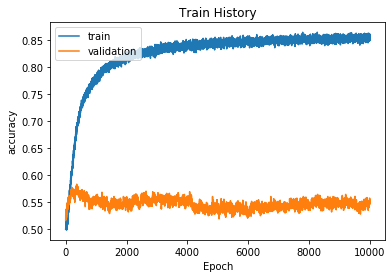

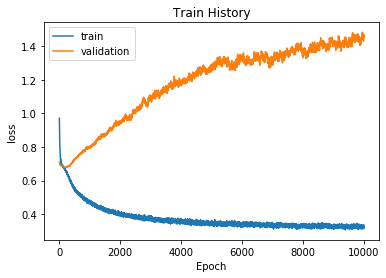

In [260]:
from obesity.model_evaluation import metric_array,show_train_history
show_train_history(model.history ,'accuracy','val_accuracy')
show_train_history(model.history ,'loss','val_loss')

In [263]:
metric_array([valid_data_embedded,valid_phenotype_data], valid_labels, model)

{'accuracy': 0.5513833992094862,
 'precision': 0.5476190476190477,
 'sensitivity': 0.5909090909090909,
 'specificity': 0.5118577075098815,
 'f1': 0.5684410646387833,
 'mcc': 0.10308941233919132}

In [264]:
metric_array([test_data_embedded,test_phenotype_data], test_labels, model)

{'accuracy': 0.5,
 'precision': 0.14847161572052403,
 'sensitivity': 0.5573770491803278,
 'specificity': 0.4908616187989556,
 'f1': 0.23448275862068968,
 'mcc': 0.03322941077543252}

In [32]:
valid_data_embedded.shape

(828, 256)

In [36]:
embedded_data = np.concatenate((train_data_embedded,valid_data_embedded))

In [37]:
embedded_data.shape

(8400, 256)

In [39]:
from sklearn.manifold import TSNE

In [59]:
X_embedded = TSNE(n_components=2,n_jobs=40,verbose=2,n_iter=2000).fit_transform(train_data_embedded)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7572 samples in 0.228s...
[t-SNE] Computed neighbors for 7572 samples in 8.178s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7572
[t-SNE] Computed conditional probabilities for sample 2000 / 7572
[t-SNE] Computed conditional probabilities for sample 3000 / 7572
[t-SNE] Computed conditional probabilities for sample 4000 / 7572
[t-SNE] Computed conditional probabilities for sample 5000 / 7572
[t-SNE] Computed conditional probabilities for sample 6000 / 7572
[t-SNE] Computed conditional probabilities for sample 7000 / 7572
[t-SNE] Computed conditional probabilities for sample 7572 / 7572
[t-SNE] Mean sigma: 3.771200
[t-SNE] Computed conditional probabilities in 0.426s
[t-SNE] Iteration 50: error = 89.3481598, gradient norm = 0.0455185 (50 iterations in 1.230s)
[t-SNE] Iteration 100: error = 68.2655945, gradient norm = 0.0218567 (50 iterations in 0.991s)
[t-SNE] Iteration 150: error = 63.0479698, gradient norm = 0

In [42]:
len(train_data_embedded)

7572

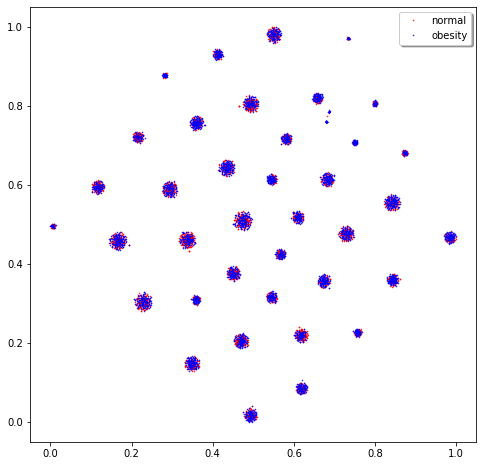

In [60]:
import matplotlib.pyplot as plt
x_min, x_max = X_embedded.min(0), X_embedded.max(0)
X_norm = (X_embedded - x_min) / (x_max - x_min)
plt.figure(figsize=(8, 8))
plt.plot(X_norm[:3786, 0], X_norm[:3786, 1],'.',color='r', markersize=1,label='normal')
plt.plot(X_norm[3786:, 0], X_norm[3786:, 1],'.',color='b', markersize=1,label='obesity')
plt.legend(loc='upper right', shadow=True) 
plt.show()

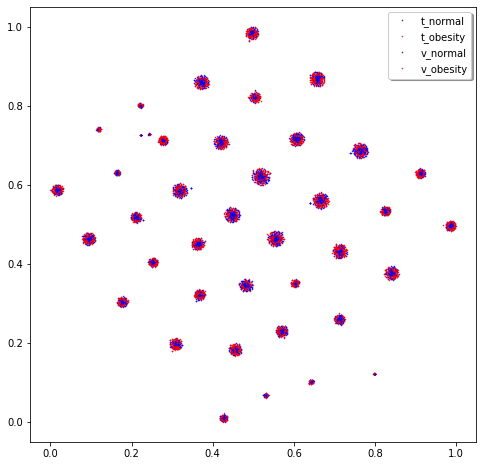

In [58]:
x_min, x_max = X_embedded.min(0), X_embedded.max(0)
X_norm = (X_embedded - x_min) / (x_max - x_min)
plt.figure(figsize=(8, 8))
plt.plot(X_norm[:3786, 0], X_norm[:3786, 1],'.',color='b', markersize=1,label='t_normal')
plt.plot(X_norm[3786:len(train_data_embedded), 0], X_norm[3786:len(train_data_embedded), 1],'.',color='r', markersize=1,label='t_obesity')
plt.plot(X_norm[len(train_data_embedded):8400, 0], X_norm[len(train_data_embedded):8400, 1],'.',color='b', markersize=1,label='v_normal')
plt.plot(X_norm[8400:, 0], X_norm[8400:, 1],'.',color='r', markersize=1,label='v_obesity')
plt.legend(loc='upper right', shadow=True) 
plt.show()

In [53]:
len(train_data_embedded)

7572

In [54]:
len(valid_labels ==1)

828

In [55]:
7572+828

8400